<a href="https://colab.research.google.com/github/yj5x/AI-tasks/blob/main/Task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import os

In [ ]:
!pip install kaggle

###📥 Uploading & Extracting Dataset from Kaggle
The chest X-ray dataset was downloaded using the Kaggle API and unzipped to prepare it for further processing.



In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### 📁 Checking Dataset Directory Hierarchy
Verified the structure of the dataset to ensure it is organized into three main folders: train, val, and test.
Each folder contains two subfolders representing the two classes: NORMAL and PNEUMONIA.

In [ ]:
import os

for dirname, _, filenames in os.walk('/content'):
    print(dirname)


/content
/content/.config
/content/.config/configurations
/content/.config/logs
/content/.config/logs/2025.07.18
/content/chest_xray
/content/chest_xray/train
/content/chest_xray/train/NORMAL
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/val
/content/chest_xray/val/NORMAL
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/__MACOSX/chest_xray/train
/content/chest_xray/__MACOSX/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/val
/content/chest_xray/__MACOSX/chest_xray/val/NORMAL
/content/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/test
/content/chest_xray/__MACOSX/chest_xray/test/NORMAL
/content/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA
/content/chest_xray/test
/content/chest_xray/test/NORMAL
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/trai

###🖼️ Displaying a Sample Pneumonia X-ray
This cell selects the first image from the PNEUMONIA training folder and displays it in grayscale. It helps visually confirm that the data is loading correctly and gives a quick sense of what the X-ray images look like.

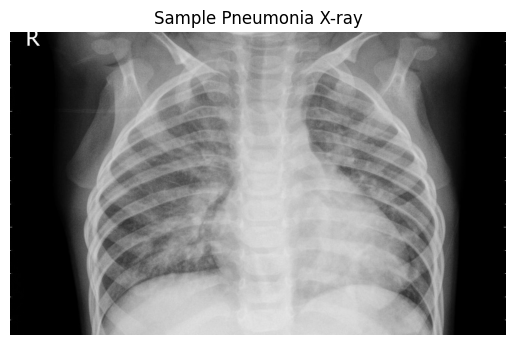

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

train_path = '/content/chest_xray/train/PNEUMONIA'
img_name = os.listdir(train_path)[0]

img_path = os.path.join(train_path, img_name)
img = mpimg.imread(img_path)

plt.imshow(img, cmap='gray')
plt.title("Sample Pneumonia X-ray")
plt.axis('off')
plt.show()

###📊 Checking Image Distribution Across Folders
This block prints the number of images for each class (NORMAL and PNEUMONIA) in the train, val, and test splits. It helps verify that the dataset is properly structured and that class distribution is reasonable.

❗However, the data distribution appears to be imbalanced — especially in the validation set, which contains a relatively small number of images. This suggests a need to balance the dataset or ensure adequate representation in each split before training.

In [ ]:
import os

base_path = '/content/chest_xray'
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

for split in splits:
    print(f"\n{split.upper()}")
    total = 0
    for cls in classes:
        path = os.path.join(base_path, split, cls)
        count = len(os.listdir(path))
        total += count
        print(f"{cls}: {count}")
    print(f"Total: {total}")



TRAIN
NORMAL: 1341
PNEUMONIA: 3875
Total: 5216

VAL
NORMAL: 8
PNEUMONIA: 8
Total: 16

TEST
NORMAL: 234
PNEUMONIA: 390
Total: 624


###📂 Data Redistribution Script
This code reorganizes the dataset into a new directory structure with a balanced 70% training, 20% validation, and 10% testing split.

* Defines original data paths: Points to existing train, val, and test folders with NORMAL and PNEUMONIA classes.

* Creates new folders under /content/data_split for the new splits and classes, ensuring the directory structure is ready.

* Collects all images from the original folders into a combined list per class (NORMAL and PNEUMONIA), disregarding the old split.

* Shuffles the combined data with a fixed random seed (42) to ensure reproducibility.

* Splits the images into new proportions: 70% train, 20% validation, and 10% test.

* Copies the images to their corresponding new folders according to the split.

**This step is essential to create a more balanced and controlled dataset split before training the model.**



In [ ]:
import os
import shutil
import random
from glob import glob

# Paths to the original data
original_dirs = {
    "train": "/content/chest_xray/train",
    "val": "/content/chest_xray/val",
    "test": "/content/chest_xray/test"
}

# New split destination
base_dest = "/content/data_split"
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# Create new folders
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dest, split, cls), exist_ok=True)

# Collect all files from train/val/test into one list
all_data = {cls: [] for cls in classes}

for split in original_dirs:
    for cls in classes:
        path = os.path.join(original_dirs[split], cls, "*")
        all_data[cls].extend(glob(path))

# Shuffle and redistribute
random.seed(42)  # for reproducibility
for cls, files in all_data.items():
    random.shuffle(files)
    n_total = len(files)
    n_train = int(0.7 * n_total)
    n_val = int(0.2 * n_total)
    n_test = n_total - n_train - n_val  # rest goes to test

    for i, file in enumerate(files):
        if i < n_train:
            split = "train"
        elif i < n_train + n_val:
            split = "val"
        else:
            split = "test"

        dest = os.path.join(base_dest, split, cls, os.path.basename(file))
        shutil.copy(file, dest)

print("✅ Data redistributed into 70/20/10 split at /content/data_split/")


✅ Data redistributed into 70/20/10 split at /content/data_split/


### Checking the new data distrbution:

In [ ]:
import os

base_path = "/content/data_split"
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

for split in splits:
    print(f"\n📁 {split.upper()} SET")
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len(os.listdir(folder))
        print(f"  {cls:10s}: {count} images")



📁 TRAIN SET
  NORMAL    : 1108 images
  PNEUMONIA : 2991 images

📁 VAL SET
  NORMAL    : 316 images
  PNEUMONIA : 854 images

📁 TEST SET
  NORMAL    : 159 images
  PNEUMONIA : 428 images


### 📊 Visualizing Data Distribution
To better understand the dataset split and class balance, we create bar charts showing the number of images per class in each dataset split (train, validation, test). This helps identify any imbalance or issues before training.

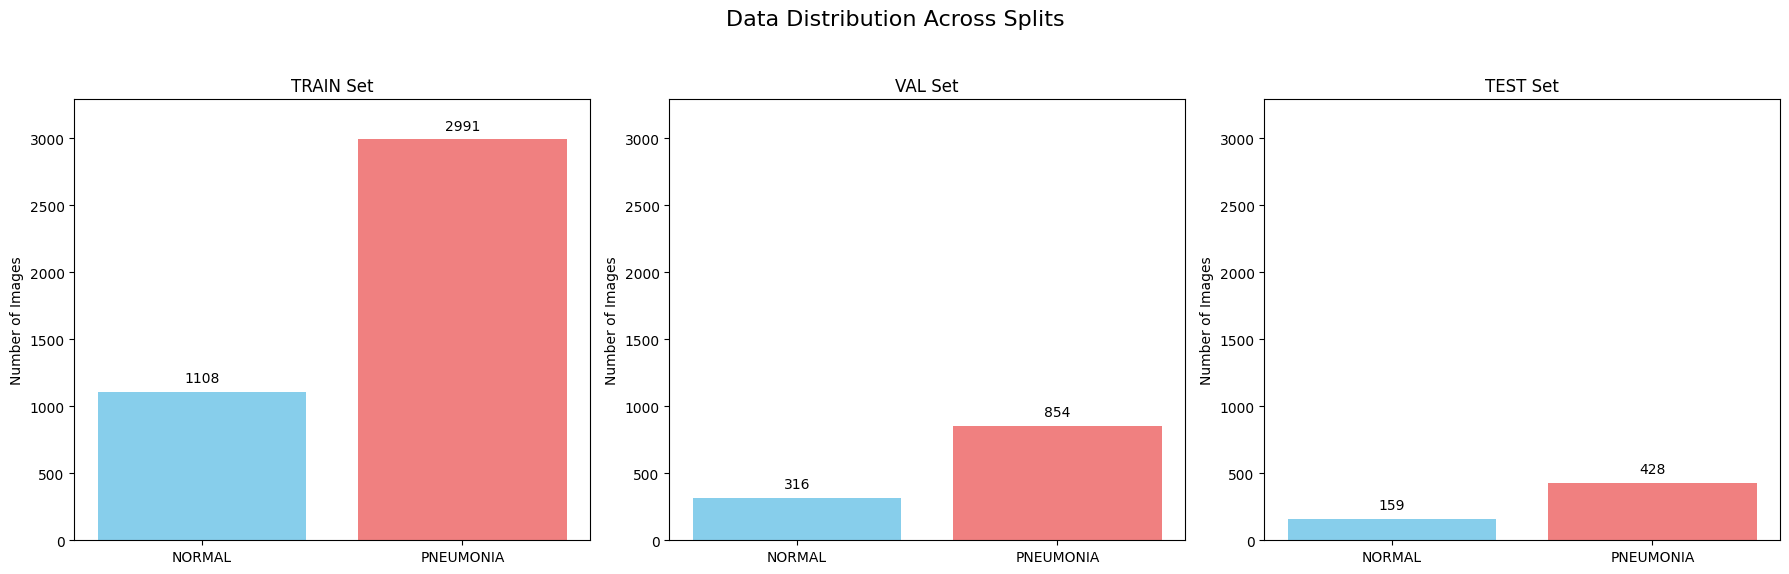

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

base_path = "/content/data_split"
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# Get counts for plotting
counts = {}
for split in splits:
    counts[split] = {}
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        counts[split][cls] = len(os.listdir(folder))

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Data Distribution Across Splits', fontsize=16)

for i, split in enumerate(splits):
    labels = counts[split].keys()
    sizes = counts[split].values()
    axes[i].bar(labels, sizes, color=['skyblue', 'lightcoral'])
    axes[i].set_title(f'{split.upper()} Set')
    axes[i].set_ylabel('Number of Images')
    axes[i].set_ylim(0, max(counts['train'].values()) * 1.1) # Consistent y-axis limit
    for j, size in enumerate(sizes):
        axes[i].text(j, size + 50, str(size), ha='center', va='bottom') # Add text labels

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

### 🎛️ Data Generators and Training Set Augmentation
This section sets up the data generators that load images from the directories and prepare them for training, validation, and testing.

For the training set, we apply data augmentation techniques such as random rotations, zooms, shifts, and horizontal flips. This artificially increases the diversity of training images, helping the model generalize better and reducing overfitting.

For the validation and test sets, only basic preprocessing is applied (such as normalization) without augmentation, to evaluate the model on unaltered data and get a realistic measure of its performance.

The data generators also handle image resizing to the input shape required by the model and batch loading for efficient training.

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = '/content/data_split/train'
val_path = '/content/data_split/val'
test_path = '/content/data_split/test'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4099 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


###🏗️ EfficientNetB0 Model Architecture Setup
We load the EfficientNetB0 base model with pretrained ImageNet weights, excluding its top classification layer.

The base model layers are frozen to retain pretrained features during initial training.

On top of the base, we add:

Global Average Pooling to reduce feature maps to a vector.

A Dropout layer (0.3) to reduce overfitting.

A Dense layer (128 units, ReLU activation) to learn task-specific features.

Batch Normalization to stabilize and speed up training.

Another Dropout (0.3) for regularization.



In [ ]:
from tensorflow.keras.layers import BatchNormalization

# Base Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###⚙️ Custom F1 Score Metric Function
This function calculates the F1 score, a harmonic mean of precision and recall, useful especially in imbalanced classification tasks.

Steps inside the function:

y_pred is rounded to 0 or 1 to get predicted class labels.

True Positives (tp): count of correct positive predictions.

False Positives (fp): count of incorrect positive predictions.

False Negatives (fn): count of missed positive cases.

Precision = tp / (tp + fp + epsilon) to avoid division by zero.

Recall = tp / (tp + fn + epsilon).

F1 score = 2 * (precision * recall) / (precision + recall + epsilon).

Returns the average F1 score over all samples/batches.

This metric is integrated into model evaluation to give a balanced measure of classification performance.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())

    return K.mean(f1)


###🛠️ Model Compilation with Metrics

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'AUC', f1_score]  # f1_score is the custom function
)

###⏸️ Early Stopping Callback
used to stop training the model automatically when it stops improving on the validation set.

In [ ]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


###🚀 Training the Model

In [ ]:
# training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 162s 986ms/step - AUC: 0.8899 - accuracy: 0.7806 - f1_score: 0.5549 - loss: 0.4739 - precision: 0.9334 - recall: 0.7580 - val_AUC: 0.9781 - val_accuracy: 0.9393 - val_f1_score: 0.6127 - val_loss: 0.2160 - val_precision: 0.9633 - val_recall: 0.9532
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 108s 843ms/step - AUC: 0.9492 - accuracy: 0.9089 - f1_score: 0.6102 - loss: 0.2428 - precision: 0.9447 - recall: 0.9294 - val_AUC: 0.9805 - val_accuracy: 0.9325 - val_f1_score: 0.6063 - val_loss: 0.1779 - val_precision: 0.9708 - val_recall: 0.9356
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 101s 781ms/step - AUC: 0.9692 - accuracy: 0.9246 - f1_score: 0.6289 - loss: 0.1987 - precision: 0.9532 - recall: 0.9450 - val_AUC: 0.9807 - val_accuracy: 0.9308 - val_f1_score: 0.5990 - val_loss: 0.1867 - val_precision: 0.9754 - val_recall: 0.9286
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 100s 776ms/step - AUC: 0.9673 - accuracy: 0.9177 - f1_score: 0.6114 - loss: 0.2013 - precision: 

In [ ]:
test_loss, test_accuracy, test_auc, test_precision, test_recall, f1_score = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test f1-score: {f1_score:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - AUC: 0.7831 - accuracy: 0.9276 - f1_score: 0.4116 - loss: 0.2045 - precision: 0.6821 - recall: 0.7660
Test accuracy: 0.9353
Test AUC: 0.9621
Test precision: 0.9486
Test recall: 0.9784
Test f1-score: 0.7183


###📊 Model Evaluation Results on Test Set


Final test metrics (after evaluation):

**Accuracy:** 93.53% - Consistently high accuracy on the test set.

**AUC:** 96.21% - Very strong class separation ability.

**Precision:** 94.86% - Most predicted positives are true positives.

**Recall:** 97.84% - Nearly all actual positives are detected.

**F1-score:** 71.83% - Good balance between precision and recall overall.



####Summary:
The model performs well with high accuracy, precision, and recall on test data, though the F1 score during training epochs suggests there may still be some room for improving the balance between precision and recall.


19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 667ms/step


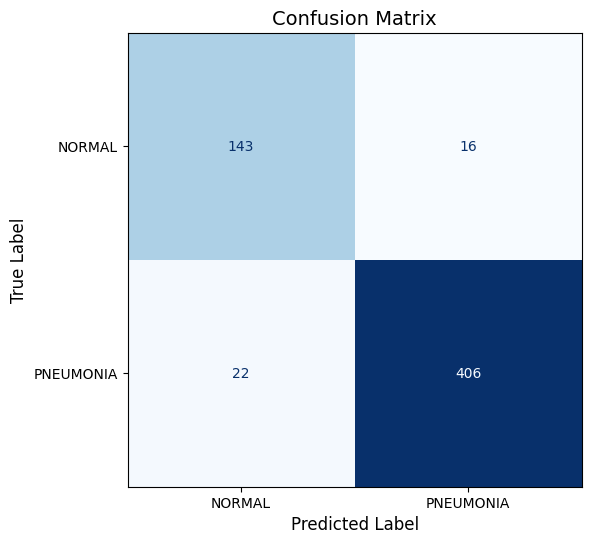

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32")  # For binary classification

# True labels
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = test_generator.class_indices
class_names = list(labels.keys())

# Plot confusion matrix with formal styling
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, colorbar=False)

# Styling
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

###📊 EfficientNetB0 Confusion Matrix Analysis
The confusion matrix reveals how well the EfficientNetB0 model performs in classifying chest X-ray images for pneumonia detection:

- True Positives (TP): 143 — Pneumonia cases correctly identified by the model, showing its ability to detect disease.

- False Negatives (FN): 16 — Pneumonia cases incorrectly classified as normal. These are clinically significant, as they represent missed diagnoses.

- False Positives (FP): 22 — Normal chest X-rays incorrectly classified as pneumonia. These errors may lead to unnecessary concern or further testing.

- True Negatives (TN): 406 — Normal cases accurately identified by the model.



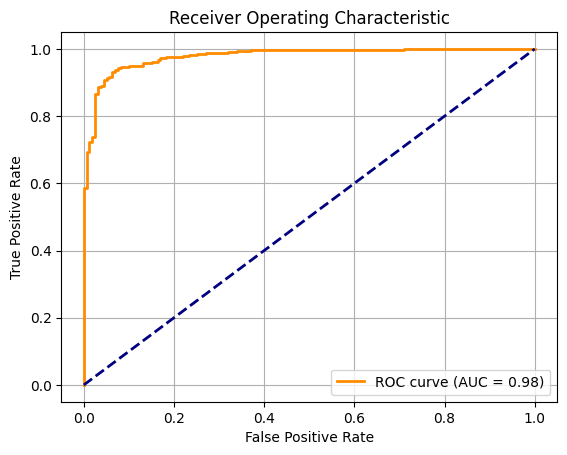

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

###📈 ROC Curve Analysis
AUC (Area Under Curve) = 0.98
This is an excellent score. It means the model has very high separability, i.e., it can distinguish between NORMAL and PNEUMONIA cases with high confidence.

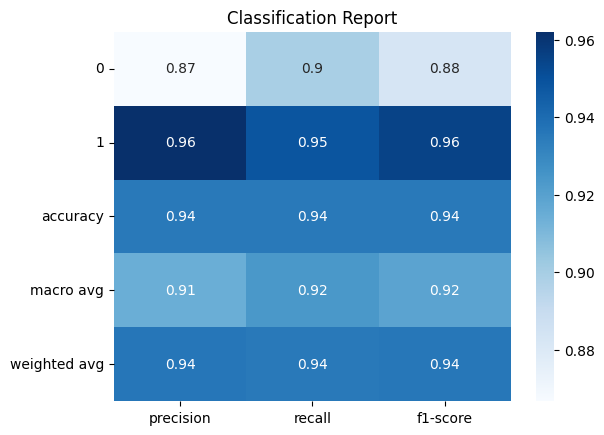

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()

#VGG 16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = '/content/data_split/train'
val_path = '/content/data_split/val'
test_path = '/content/data_split/test'


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4099 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


### VGG16 Model Setup 🖼️

- We load the **VGG16** model pretrained on ImageNet **without the top classification layers**.
- Input size remains `(224, 224, 3)` to match VGG16 requirements.
- The base model is **frozen** to keep pretrained weights fixed during initial training.
- On top, we add:
  - A **Flatten** layer to convert feature maps to a vector.
  - A **Dense** layer with 256 units and ReLU activation.
  - A **Dropout** layer with 0.5 rate for regularization.
  - A final **Dense** layer with 1 unit and sigmoid activation for binary classification.
- This architecture is simpler compared to EfficientNet's GlobalAveragePooling + BatchNorm block.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the full model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


###⚙️ Custom F1 Score Metric Function

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())

    return K.mean(f1)

###🛠️ Model Compilation with Metrics

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'AUC', f1_score]
)


###⏸️ Early Stopping Callback

In [ ]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

###🚀 Training the Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  ,
    callbacks=[early_stopping]

)


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 128s 870ms/step - AUC: 0.8355 - accuracy: 0.8521 - f1_score: 0.6103 - loss: 5.5340 - precision: 0.9037 - recall: 0.8935 - val_AUC: 0.9868 - val_accuracy: 0.9487 - val_f1_score: 0.6038 - val_loss: 0.1569 - val_precision: 0.9818 - val_recall: 0.9473
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 98s 761ms/step - AUC: 0.9682 - accuracy: 0.9161 - f1_score: 0.6320 - loss: 0.2203 - precision: 0.9346 - recall: 0.9527 - val_AUC: 0.9841 - val_accuracy: 0.9462 - val_f1_score: 0.6067 - val_loss: 0.1823 - val_precision: 0.9771 - val_recall: 0.9485
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 97s 750ms/step - AUC: 0.9746 - accuracy: 0.9243 - f1_score: 0.6188 - loss: 0.1953 - precision: 0.9453 - recall: 0.9513 - val_AUC: 0.9875 - val_accuracy: 0.9299 - val_f1_score: 0.5899 - val_loss: 0.2014 - val_precision: 0.9923 - val_recall: 0.9110
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 104s 808ms/step - AUC: 0.9715 - accuracy: 0.9268 - f1_score: 0.5998 - loss: 0.2036 - precision: 0.

In [ ]:
test_loss, test_accuracy, test_auc, test_precision, test_recall, f1_score = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test f1-score: {f1_score:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step - AUC: 0.7905 - accuracy: 0.9527 - f1_score: 0.4121 - loss: 0.1166 - precision: 0.7118 - recall: 0.7669
Test accuracy: 0.9557
Test AUC: 0.9786
Test precision: 0.9603
Test recall: 0.9880
Test f1-score: 0.7225


### VGG16 Model Evaluation Summary ✅

- **Test Accuracy:** 95.57% — The model correctly classifies most samples.
- **Test AUC:** 0.9786 — Excellent ability to distinguish between classes.
- **Test Precision:** 96.03% — High proportion of predicted positives are true positives.
- **Test Recall:** 98.80% — The model successfully detects most of the actual positives.
- **Test F1-Score:** 0.7225 — Balanced performance considering precision and recall, indicating good overall effectiveness despite class imbalance.

The model performs strongly, especially in distinguishing pneumonia cases, but there’s room to improve F1-score further by tuning or data strategies.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 577ms/step


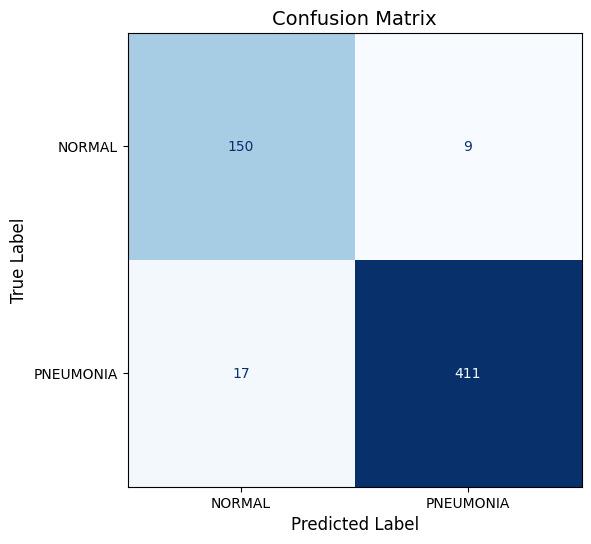

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32")  # For binary classification

# True labels
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = test_generator.class_indices
class_names = list(labels.keys())

# Plot confusion matrix with formal styling
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, colorbar=False)

# Styling
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

### Confusion Matrix Analysis 📊

- **True Positives (TP):** 150 — Correctly identified pneumonia cases.
- **False Negatives (FN):** 9 — Pneumonia cases missed by the model.
- **False Positives (FP):** 17 — Normal cases incorrectly flagged as pneumonia.
- **True Negatives (TN):** 411 — Correctly identified normal cases.

🔍 **Insights:**
- The model is highly sensitive, missing only 9 positive cases (FN), which explains the **high recall (98.8%)**.
- The **17 false positives** slightly reduce precision (96.03%), but the trade-off is acceptable in a medical context where catching positive cases is often prioritized.


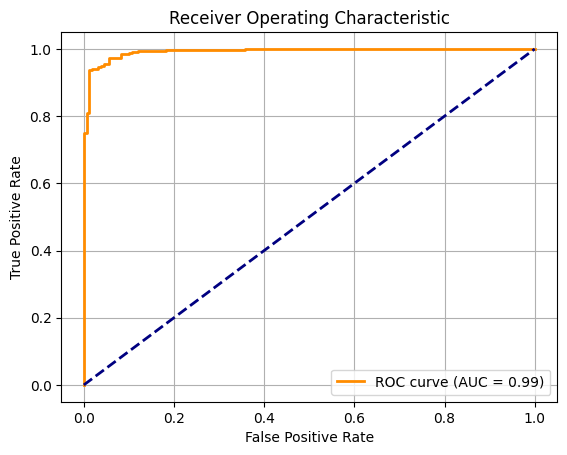

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

> 📈 **The AUC (Area Under the Curve) for VGG16 reaches  0.98**, indicating that the model has excellent discriminative ability. This high AUC value means VGG16 is very effective at distinguishing between pneumonia and normal cases, achieving near-perfect performance in terms of true positive vs. false positive rates across various thresholds. Such a score highlights the model's strong potential for real-world diagnostic support.


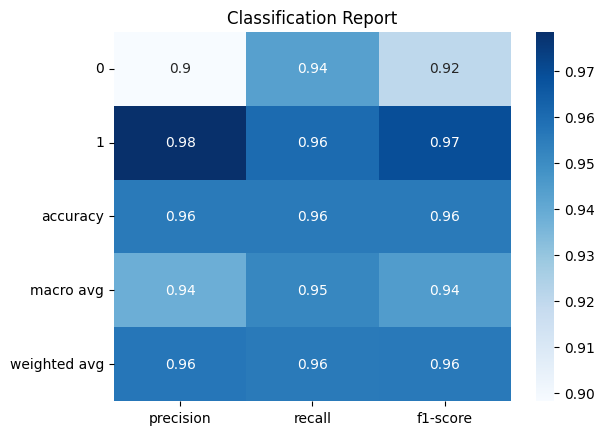

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()

## 🔬 Model Comparison: EfficientNetB0 vs VGG16

### 🧪 Evaluation Metrics

#### 📈 **EfficientNetB0**
-  **Test Accuracy:** 93.53%  
-  **Test AUC:** 0.9621  
-  **Precision:** 0.9486  
-  **Recall:** 0.9784  
-  **F1-score:** 0.7183  


#### 🧠 **VGG16**
-  **Test Accuracy:** 95.57%  
-  **Test AUC:** 0.9786  
-  **Precision:** 0.9603  
-  **Recall:** 0.9880  
-  **F1-score:** 0.7225  


Comparison:

Both models performed very well on the test set.
- **VGG16** shows **slightly better performance** across most metrics:  
  - Higher **accuracy**, **AUC**, **precision**, and **recall**.  
- **F1-scores** are **quite similar**, showing a comparable balance between precision and recall.  
- 🧾 **Confusion matrices** reveal:
  - A high number of **true positives**.
  - A low number of **false negatives** — crucial for detecting pneumonia.
- 📉 **ROC curves** confirm **excellent discriminative power** for both (high AUCs).



### 💡 Suggestion & Insights

- 🥇 **VGG16** is the **slightly better choice**, especially for minimizing missed cases (high recall).  
- ⚖️ However, **EfficientNetB0** is still **very competitive**, and might be preferred when:
  - **Inference speed** or  
  - **Model size** is a constraint.  
- 🧠 For **critical medical applications**, consider:
  - Further validation  
  - **Model ensembling** to boost reliability and robustness.  
